In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import warnings
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
warnings.filterwarnings('ignore')
%matplotlib inline  

In [2]:
data = pd.read_csv('sales_transactions.csv')

In [3]:
data.head()

,Product_Code,W0,W1,W2,W3,W4,W5,W6,W7,W8,...,Normalized 42,Normalized 43,Normalized 44,Normalized 45,Normalized 46,Normalized 47,Normalized 48,Normalized 49,Normalized 50,Normalized 51
0,P1,11,12,10,8,13,12,14,21,6,...,0.06,0.22,0.28,0.39,0.50,0.00,0.22,0.17,0.11,0.39
1,P2,7,6,3,2,7,1,6,3,3,...,0.20,0.40,0.50,0.10,0.10,0.40,0.50,0.10,0.60,0.00
2,P3,7,11,8,9,10,8,7,13,12,...,0.27,1.00,0.18,0.18,0.36,0.45,1.00,0.45,0.45,0.36
3,P4,12,8,13,5,9,6,9,13,13,...,0.41,0.47,0.06,0.12,0.24,0.35,0.71,0.35,0.29,0.35
4,P5,8,5,13,11,6,7,9,14,9,...,0.27,0.53,0.27,0.60,0.20,0.20,0.13,0.53,0.33,0.40


In [4]:
data.columns

Index(['Product_Code', 'W0', 'W1', 'W2', 'W3', 'W4', 'W5', 'W6', 'W7', 'W8',
       ...
       'Normalized 42', 'Normalized 43', 'Normalized 44', 'Normalized 45',
       'Normalized 46', 'Normalized 47', 'Normalized 48', 'Normalized 49',
       'Normalized 50', 'Normalized 51'],
      dtype='object', length=107)

In [5]:
data = data[data.columns[:-54]]

In [6]:
data.columns

Index(['Product_Code', 'W0', 'W1', 'W2', 'W3', 'W4', 'W5', 'W6', 'W7', 'W8',
       'W9', 'W10', 'W11', 'W12', 'W13', 'W14', 'W15', 'W16', 'W17', 'W18',
       'W19', 'W20', 'W21', 'W22', 'W23', 'W24', 'W25', 'W26', 'W27', 'W28',
       'W29', 'W30', 'W31', 'W32', 'W33', 'W34', 'W35', 'W36', 'W37', 'W38',
       'W39', 'W40', 'W41', 'W42', 'W43', 'W44', 'W45', 'W46', 'W47', 'W48',
       'W49', 'W50', 'W51'],
      dtype='object')

In [7]:
data_ = data.melt(id_vars='Product_Code', var_name='Week', value_name='Sales')

In [8]:
data_

,Product_Code,Week,Sales
0,P1,W0,11
1,P2,W0,7
2,P3,W0,7
3,P4,W0,12
4,P5,W0,8
...,...,...,...
42167,P815,W51,0
42168,P816,W51,5
42169,P817,W51,3
42170,P818,W51,0


In [9]:
data_['Product_Code'] = data_['Product_Code'].str.extract('(\d+)', expand=False).astype(int)
data_['Week'] = data_['Week'].str.extract('(\d+)', expand=False).astype(int)

data_ = data_.sort_values(['Week', 'Product_Code'])
data_.head()

,Product_Code,Week,Sales
0,1,0,11
1,2,0,7
2,3,0,7
3,4,0,12
4,5,0,8


In [10]:
data_['Last_Week_Sales'] = data_.groupby(['Product_Code'])['Sales'].shift()
data_['Last_Week_Diff'] = data_.groupby(['Product_Code'])['Last_Week_Sales'].diff()
data_ = data_.dropna()
data_.head()

,Product_Code,Week,Sales,Last_Week_Sales,Last_Week_Diff
1622,1,2,10,12.0,1.0
1623,2,2,3,6.0,-1.0
1624,3,2,8,11.0,4.0
1625,4,2,13,8.0,-4.0
1626,5,2,13,5.0,-3.0


In [11]:
def rmsle(ytrue, ypred):
    return np.sqrt(mean_squared_log_error(ytrue, ypred))

In [12]:
mean_error = []
for week in range(40,52):
    train = data_[data_['Week'] < week]
    val = data_[data_['Week'] == week]
    
    p = val['Last_Week_Sales'].values
    
    error = rmsle(val['Sales'].values, p)
    print('Week %d - Error %.5f' % (week, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

Week 40 - Error 0.51952
Week 41 - Error 0.51691
Week 42 - Error 0.51026
Week 43 - Error 0.50792
Week 44 - Error 0.53409
Week 45 - Error 0.52347
Week 46 - Error 0.50018
Week 47 - Error 0.49138
Week 48 - Error 0.50585
Week 49 - Error 0.50547
Week 50 - Error 0.52220
Week 51 - Error 0.55242
Mean Error = 0.51581


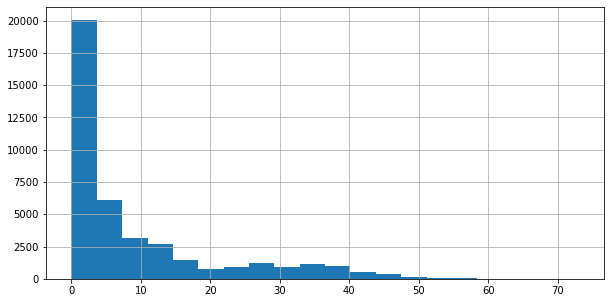

In [13]:

data_['Sales'].hist(bins=20, figsize=(10,5))

In [14]:
mean_error = []
for week in range(40,52):
    train = data_[data_['Week'] < week]
    val = data_[data_['Week'] == week]
    
    xtr, xts = train.drop(['Sales'], axis=1), val.drop(['Sales'], axis=1)
    ytr, yts = train['Sales'].values, val['Sales'].values
    
    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdl.fit(xtr, ytr)
    
    p = mdl.predict(xts)
    
    error = rmsle(yts, p)
    print('Week %d - Error %.5f' % (week, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

Week 40 - Error 0.46242
Week 41 - Error 0.45964
Week 42 - Error 0.46166
Week 43 - Error 0.46655
Week 44 - Error 0.47122
Week 45 - Error 0.43100
Week 46 - Error 0.47183
Week 47 - Error 0.44945
Week 48 - Error 0.46080
Week 49 - Error 0.44696
Week 50 - Error 0.47465
Week 51 - Error 0.48651
Mean Error = 0.46189


In [15]:
data_['Last_Week_Sales'] = data_.groupby(['Product_Code'])['Sales'].shift()
data_['Last_Week_Diff'] = data_.groupby(['Product_Code'])['Last_Week_Sales'].diff()
data_['Last-1_Week_Sales'] = data_.groupby(['Product_Code'])['Sales'].shift(2)
data_['Last-1_Week_Diff'] = data_.groupby(['Product_Code'])['Last-1_Week_Sales'].diff()
data_ = data_.dropna()
data_.head()

,Product_Code,Week,Sales,Last_Week_Sales,Last_Week_Diff,Last-1_Week_Sales,Last-1_Week_Diff
4055,1,5,12,13.0,5.0,8.0,-2.0
4056,2,5,1,7.0,5.0,2.0,-1.0
4057,3,5,8,10.0,1.0,9.0,1.0
4058,4,5,6,9.0,4.0,5.0,-8.0
4059,5,5,7,6.0,-5.0,11.0,-2.0


In [16]:
mean_error = []
for week in range(40,52):
    train = data_[data_['Week'] < week]
    val = data_[data_['Week'] == week]
    
    xtr, xts = train.drop(['Sales'], axis=1), val.drop(['Sales'], axis=1)
    ytr, yts = train['Sales'].values, val['Sales'].values
    
    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdl.fit(xtr, ytr)
    
    p = mdl.predict(xts)
    
    error = rmsle(yts, p)
    print('Week %d - Error %.5f' % (week, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

Week 40 - Error 0.44177
Week 41 - Error 0.45674
Week 42 - Error 0.43732
Week 43 - Error 0.44031
Week 44 - Error 0.46188
Week 45 - Error 0.42276
Week 46 - Error 0.45799
Week 47 - Error 0.44506
Week 48 - Error 0.44577
Week 49 - Error 0.43648
Week 50 - Error 0.47421
Week 51 - Error 0.46556
Mean Error = 0.44882


In [17]:
data_['Last_Week_Sales'] = data_.groupby(['Product_Code'])['Sales'].shift()
data_['Last_Week_Diff'] = data_.groupby(['Product_Code'])['Last_Week_Sales'].diff()
data_['Last-1_Week_Sales'] = data_.groupby(['Product_Code'])['Sales'].shift(2)
data_['Last-1_Week_Diff'] = data_.groupby(['Product_Code'])['Last-1_Week_Sales'].diff()
data_['Last-2_Week_Sales'] = data_.groupby(['Product_Code'])['Sales'].shift(3)
data_['Last-2_Week_Diff'] = data_.groupby(['Product_Code'])['Last-2_Week_Sales'].diff()
data_ = data_.dropna()
data_.head()

,Product_Code,Week,Sales,Last_Week_Sales,Last_Week_Diff,Last-1_Week_Sales,Last-1_Week_Diff,Last-2_Week_Sales,Last-2_Week_Diff
7299,1,9,14,6.0,-15.0,21.0,7.0,14.0,2.0
7300,2,9,3,3.0,0.0,3.0,-3.0,6.0,5.0
7301,3,9,6,12.0,-1.0,13.0,6.0,7.0,-1.0
7302,4,9,11,13.0,0.0,13.0,4.0,9.0,3.0
7303,5,9,9,9.0,-5.0,14.0,5.0,9.0,2.0


In [18]:
mean_error = []
for week in range(40,52):
    train = data_[data_['Week'] < week]
    val = data_[data_['Week'] == week]
    
    xtr, xts = train.drop(['Sales'], axis=1), val.drop(['Sales'], axis=1)
    ytr, yts = train['Sales'].values, val['Sales'].values
    
    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdl.fit(xtr, ytr)
    
    p = mdl.predict(xts)
    
    error = rmsle(yts, p)
    print('Week %d - Error %.5f' % (week, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

Week 40 - Error 0.43130
Week 41 - Error 0.43943
Week 42 - Error 0.42656
Week 43 - Error 0.41979
Week 44 - Error 0.44553
Week 45 - Error 0.40550
Week 46 - Error 0.43932
Week 47 - Error 0.43116
Week 48 - Error 0.43662
Week 49 - Error 0.42979
Week 50 - Error 0.45922
Week 51 - Error 0.45425
Mean Error = 0.43487


In [19]:
mean_error = []
for week in range(40,52):
    train = data_[data_['Week'] < week]
    val = data_[data_['Week'] == week]
    
    xtr, xts = train.drop(['Sales'], axis=1), val.drop(['Sales'], axis=1)
    ytr, yts = train['Sales'].values, val['Sales'].values
    
    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdl.fit(xtr, np.log1p(ytr))
    
    p = np.expm1(mdl.predict(xts))
    
    error = rmsle(yts, p)
    print('Week %d - Error %.5f' % (week, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

Week 40 - Error 0.41875
Week 41 - Error 0.42149
Week 42 - Error 0.41169
Week 43 - Error 0.40389
Week 44 - Error 0.43205
Week 45 - Error 0.39496
Week 46 - Error 0.42712
Week 47 - Error 0.41147
Week 48 - Error 0.42856
Week 49 - Error 0.43836
Week 50 - Error 0.44545
Week 51 - Error 0.47264
Mean Error = 0.42554
